In [1]:
import pandas as pd
import pandana as pdna
from pandana.loaders import osm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import osmnx as ox
import os
import timeit

ox.settings.use_cache = True

ox.settings.log_console = True

In [2]:
start = timeit.timeit() #timing
#osmnx
filepath = "./data/aalborg_network.graphml"
if(os.path.exists(filepath)):
    G = ox.io.load_graphml(filepath)
else:
    #bbox = 12.4763, 55.5504, 12.6878, 55.7016
    #G = ox.graph.graph_from_bbox(bbox, simplify = True, network_type="walk")  
    G = ox.graph.graph_from_place("Aalborg Municipality, Denmark")
    ox.io.save_graphml(G, filepath)

G = ox.project_graph(G)

#pandana
filepath_pan = "./data/aalborg_features.h5"

if(os.path.exists(filepath_pan)):
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network.from_hdf5(filepath_pan)
else:
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network(n.geometry.x, n.geometry.y, e["u"], e["v"], e[["length"]])
    
    network.save_hdf5(filepath_pan)

places = ["Aalborg Municipality, Denmark",]

pois_a = ox.features_from_place(
    places,
    tags={"amenity": "bus_station", "shop": "supermarket", "shop": "convenience"},
).to_crs(n.crs)

pois_b = ox.features_from_place(
    places,
    tags={"amenity": "clinic", "amenity": "pharmacy"},
).to_crs(n.crs)
pois_c = ox.features_from_place(
    places,
    tags={"amenity": "school"},
).to_crs(n.crs)

pois_a = pois_a.copy()
pois_a["geometry"] = pois_a.geometry.centroid

pois_b = pois_b.copy()
pois_b["geometry"] = pois_b.geometry.centroid

pois_c = pois_c.copy()
pois_c["geometry"] = pois_c.geometry.centroid
dist = 1000

network.set_pois(
    category="pois_a",
    maxdist=2000,
    maxitems=1000,
    x_col=pois_a.geometry.x,
    y_col=pois_a.geometry.y,
)
network.set_pois(
    category="pois_b",
    maxdist=2000,
    maxitems=1000,
    x_col=pois_b.geometry.x,
    y_col=pois_b.geometry.y,
)
network.set_pois(
    category="pois_c",
    maxdist=2000,
    maxitems=1000,
    x_col=pois_c.geometry.x,
    y_col=pois_c.geometry.y,
)
nearest_pois_a = network.nearest_pois(
    distance=2000,
    category="pois_a",
    num_pois=50,
)
n["pois_a"] = (nearest_pois_a <= dist).sum(axis=1)
nearest_pois_b = network.nearest_pois(
    distance=2000,
    category="pois_b",
    num_pois=50,
)
n["pois_b"] = (nearest_pois_b <= dist).sum(axis=1)

nearest_pois_c = network.nearest_pois(
    distance=2000,
    category="pois_c",
    num_pois=50,
)
n["pois_c"] = (nearest_pois_c <= dist).sum(axis=1)

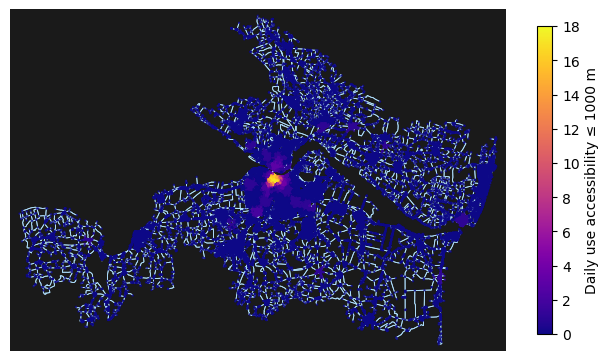

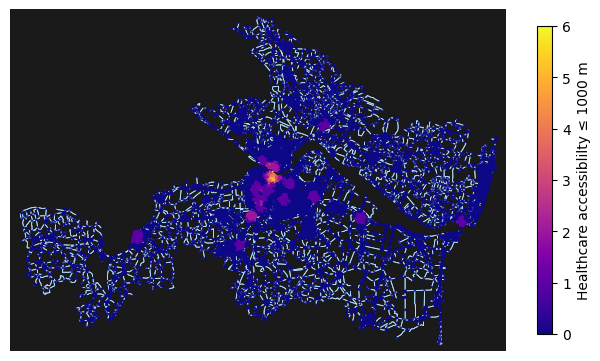

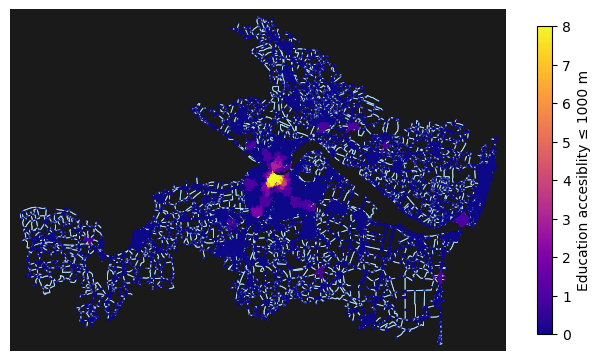

In [3]:
fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)

vmin = n["pois_a"].min()
vmax = n["pois_a"].max()

n.plot(
    ax=ax,
    column="pois_a",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        "shrink": 0.5,
        "label": f"Daily use accessibility ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)

plt.show()

fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)

vmin = n["pois_b"].min()
vmax = n["pois_b"].max()

n.plot(
    ax=ax,
    column="pois_b",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        "shrink": 0.5,
        "label": f"Healthcare accessiblilty ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)

plt.show()

fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)

vmin = n["pois_c"].min()
vmax = n["pois_c"].max()

n.plot(
    ax=ax,
    column="pois_a",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        "shrink": 0.5,
        "label": f"Education accesiblity ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)

plt.show()